In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten, Reshape, InputLayer, Input

import matplotlib.pyplot as plt
import numpy as np

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
metadata_path = 'drive/MyDrive/DA23/CIFAR-100/meta'
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

In [5]:
data_pre_path = 'drive/MyDrive/DA23/CIFAR-100/'
# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'coarse_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'coarse_labels'])

In [6]:
def linear_to_img(linear):
  linear = np.array(linear) / 255
  return linear.reshape(3, 32, 32).swapaxes(0, 1).swapaxes(1, 2)

In [7]:
print(data_test[0].shape)

(3072,)


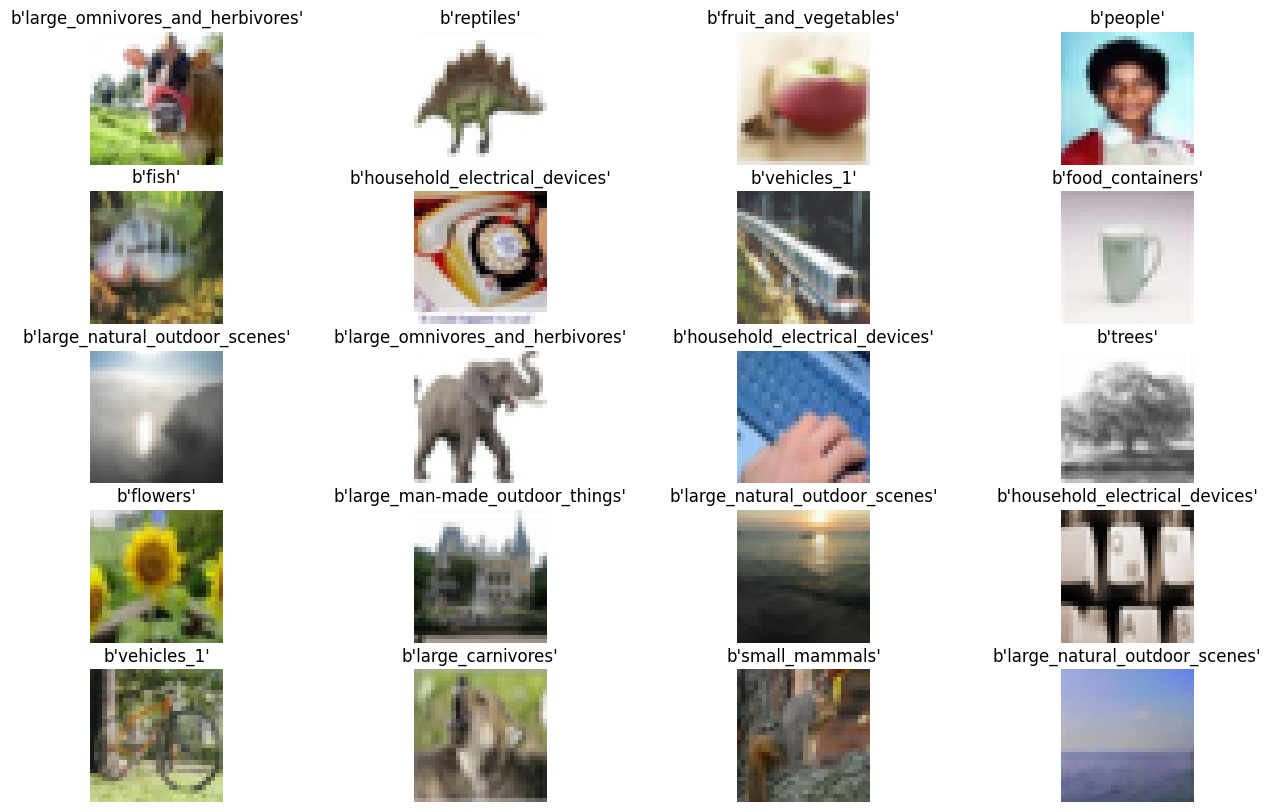

In [8]:
n = 20
plt.figure(figsize=(16, 10))
for i in range(n):
    img = linear_to_img(data_train[i])
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(superclass_dict[label_train[i]])
    plt.axis("off")

plt.show()

In [9]:
x_train = np.array([2 * linear_to_img(data_train[i]) - 1 for i in range(data_train.shape[0])])
x_test = np.array([2 * linear_to_img(data_test[i]) - 1 for i in range(data_test.shape[0])])

# Build model

In [10]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
latent_dim = 96

In [11]:
def build_discriminator():
  model = Sequential([
      Input(shape=(32, 32, 3)),
      Conv2D(32, (3, 3), padding='same'),
      LeakyReLU(alpha=0.3),
      Conv2D(64, (3, 3), padding='same'),
      LeakyReLU(alpha=0.2),
      Conv2D(128, (3, 3), padding='same', strides=(2, 2)),
      LeakyReLU(alpha=0.2),
      Conv2D(256, (3, 3), padding='same', strides=(2, 2)),
      LeakyReLU(alpha=0.5),
      Flatten(),
      Dropout(0.3),
      Dense(1, 'sigmoid')
  ])
  model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
  return model

def build_generator():
  return Sequential([
      InputLayer((latent_dim,)),
      Dense(4 * 4 * 128),
      LeakyReLU(alpha=0.2),
      Reshape((4, 4, 128)),
      # up to 8x8x64
      Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
      LeakyReLU(alpha=0.2),
      # up to 16x16x32
      Conv2DTranspose(32, (4,4), strides=(2, 2), padding='same'),
      LeakyReLU(alpha=0.2),
      # up to 32x32x16
      Conv2DTranspose(16, (4,4), strides=(2, 2), padding='same'),
      LeakyReLU(alpha=0.2),
      # to result image
      Conv2D(3, (3,3), activation='tanh', padding='same')
  ])

def build_gan(generator, discriminator):
  discriminator.trainable = False
  model = Sequential([
      generator,
      discriminator
  ])

  model.compile(loss='binary_crossentropy', optimizer=optim)
  return model

In [12]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [21]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

             # Generate fake CIFAR images
            generated_images = generator.predict(noise, verbose=0)

            X = np.concatenate([image_batch, generated_images])
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 1 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

epoch:  0
1/1 [==============================] - 0s 94ms/step


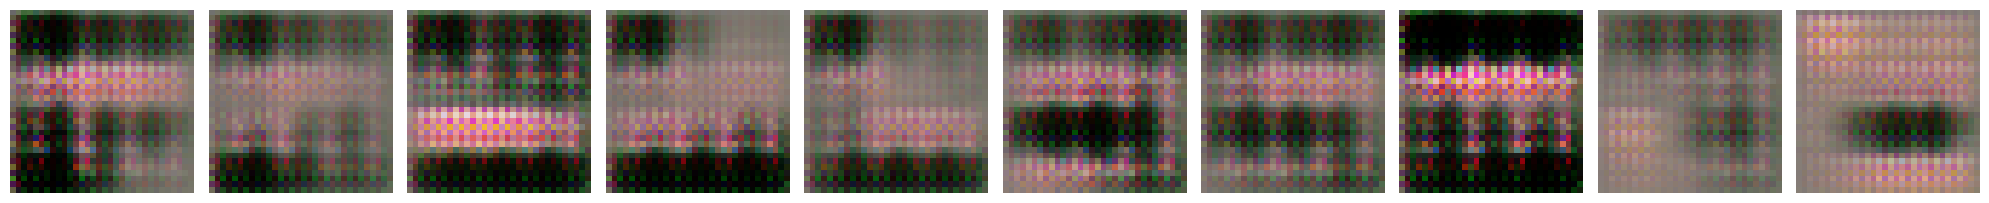

epoch:  1
1/1 [==============================] - 0s 16ms/step


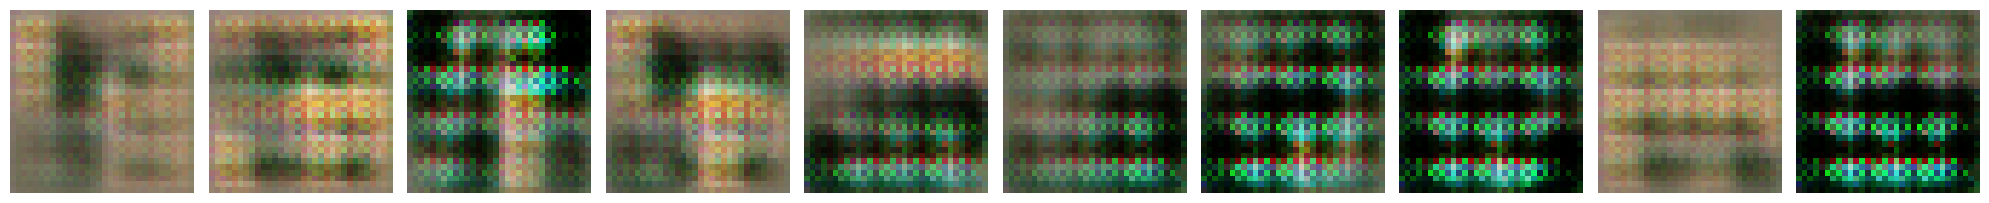

epoch:  2
1/1 [==============================] - 0s 16ms/step


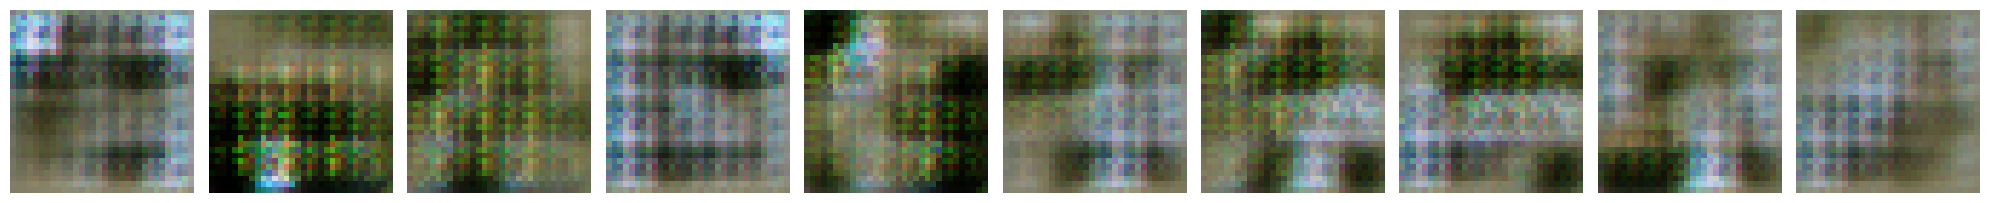

epoch:  3
1/1 [==============================] - 0s 17ms/step


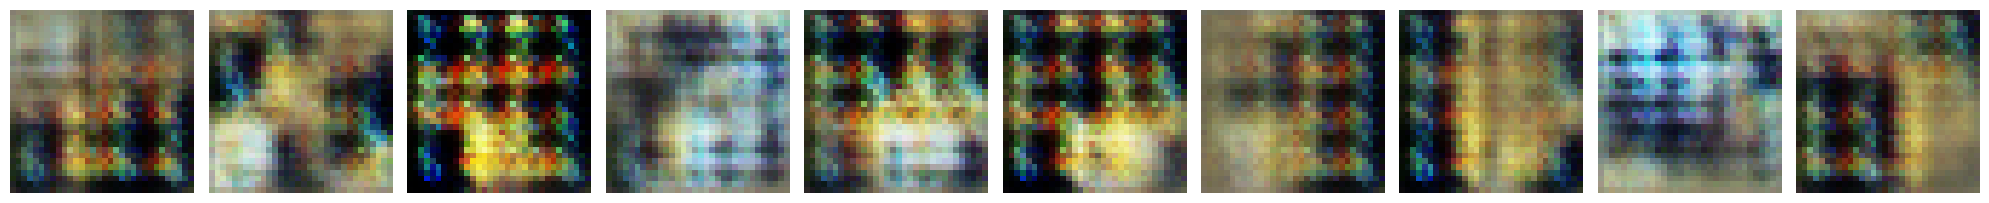

epoch:  4
1/1 [==============================] - 0s 25ms/step


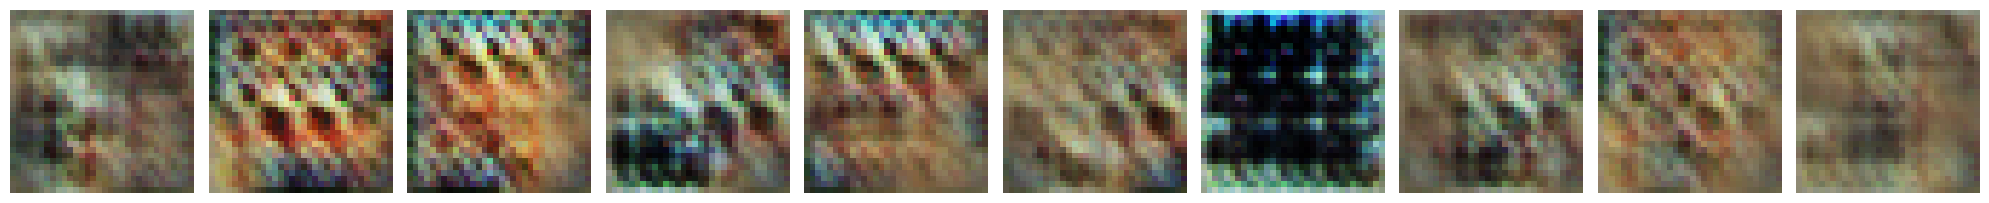

epoch:  5
1/1 [==============================] - 0s 19ms/step


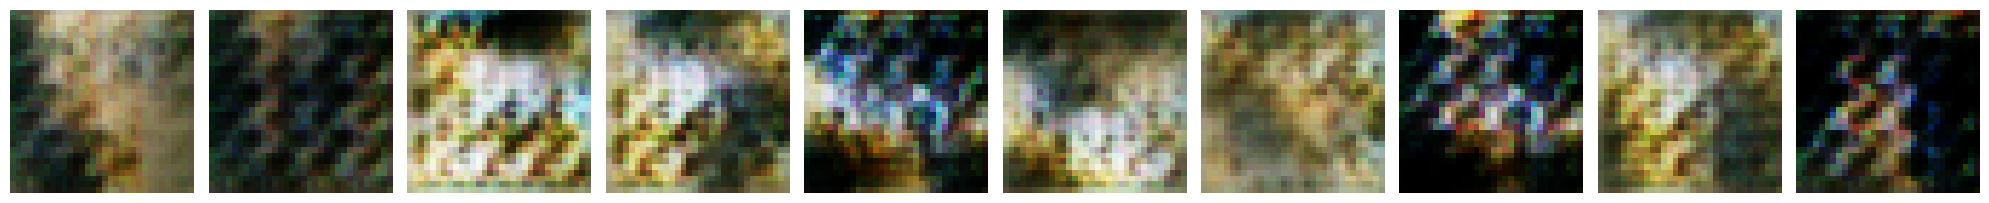

epoch:  6
1/1 [==============================] - 0s 16ms/step


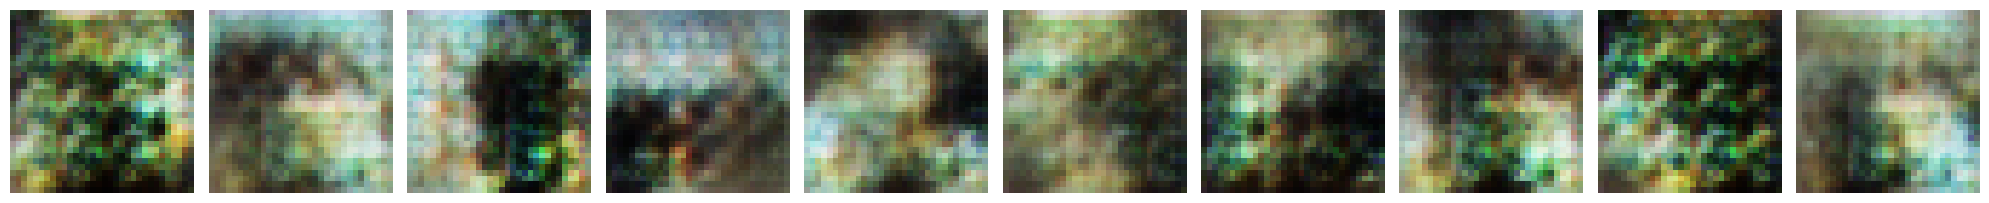

epoch:  7
1/1 [==============================] - 0s 16ms/step


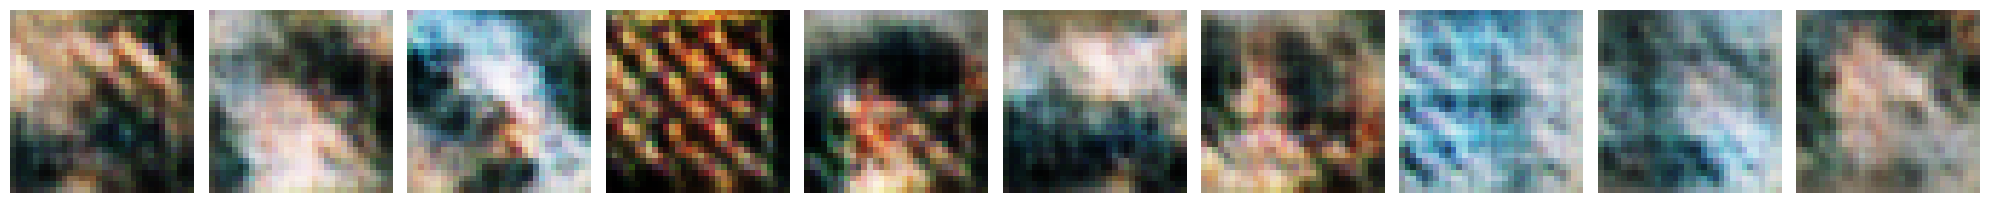

epoch:  8
1/1 [==============================] - 0s 16ms/step


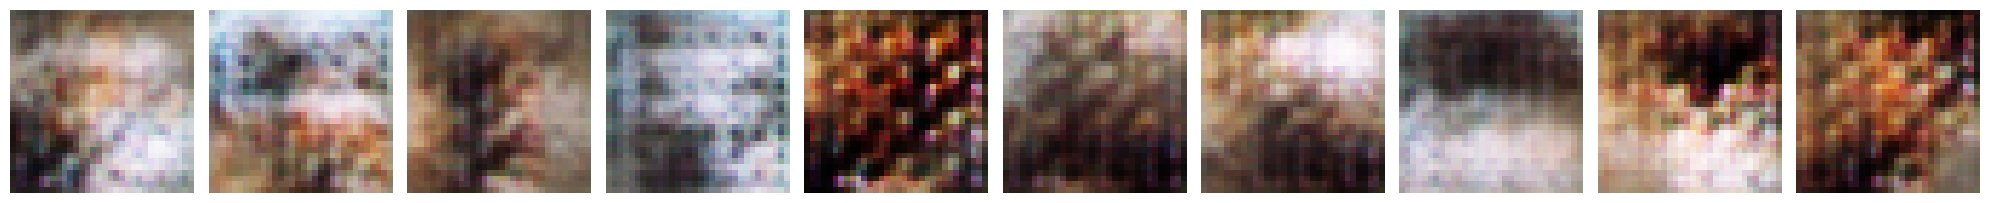

epoch:  9
1/1 [==============================] - 0s 17ms/step


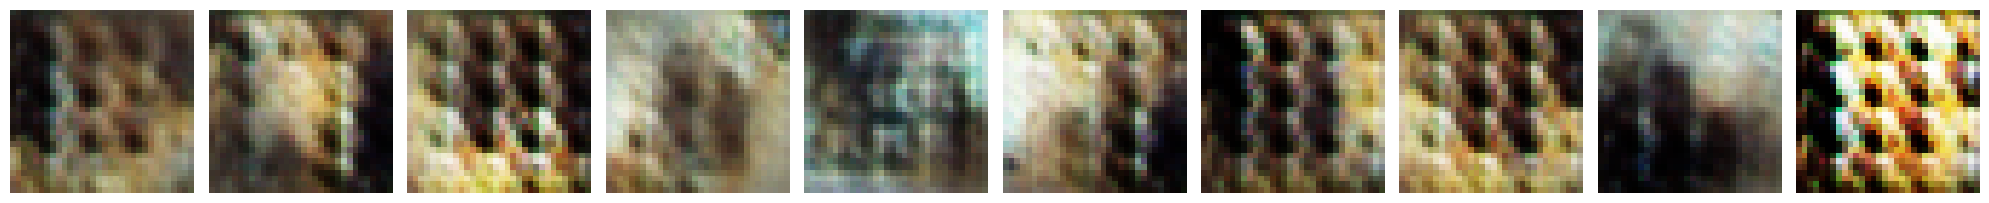

epoch:  10
1/1 [==============================] - 0s 19ms/step


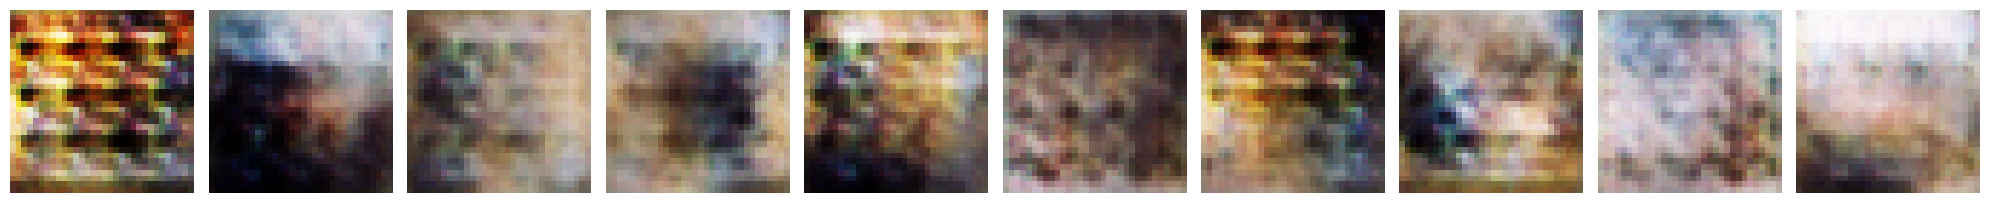

epoch:  11
1/1 [==============================] - 0s 16ms/step


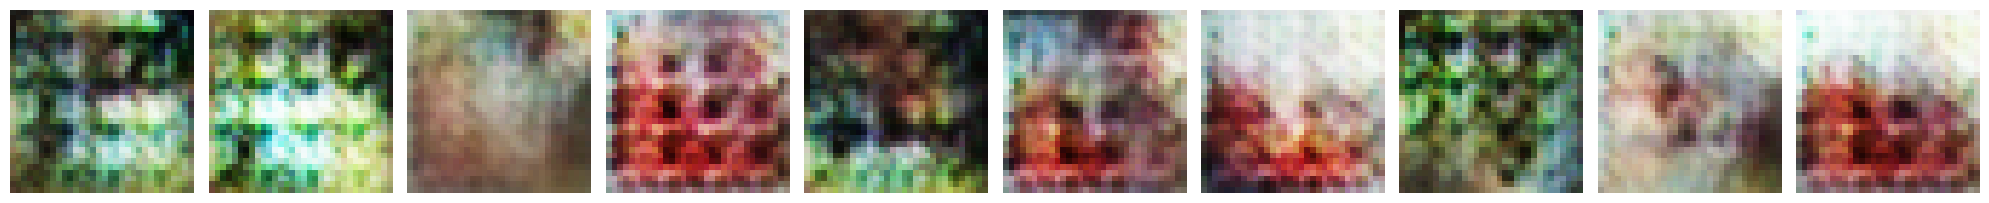

epoch:  12
1/1 [==============================] - 0s 16ms/step


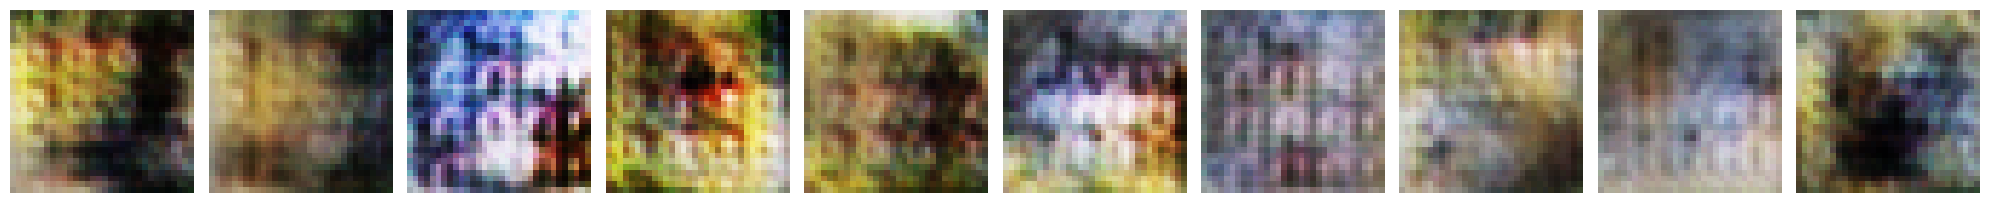

epoch:  13
1/1 [==============================] - 0s 16ms/step


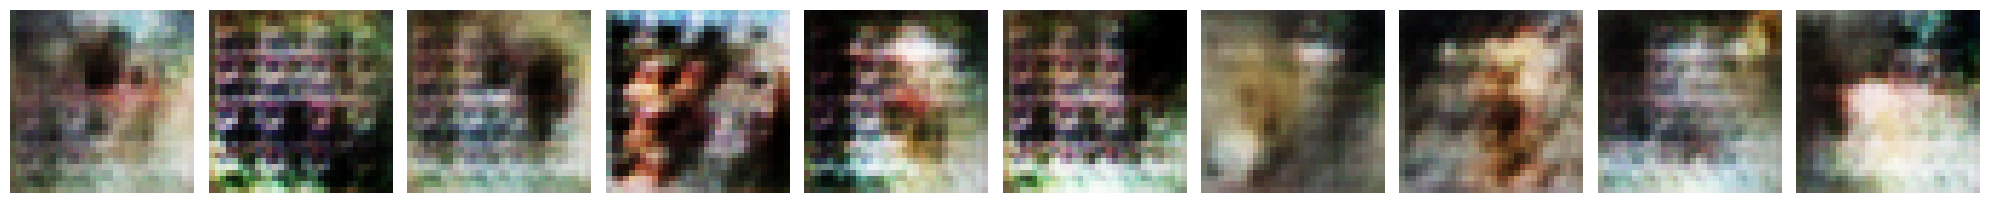

epoch:  14
1/1 [==============================] - 0s 16ms/step


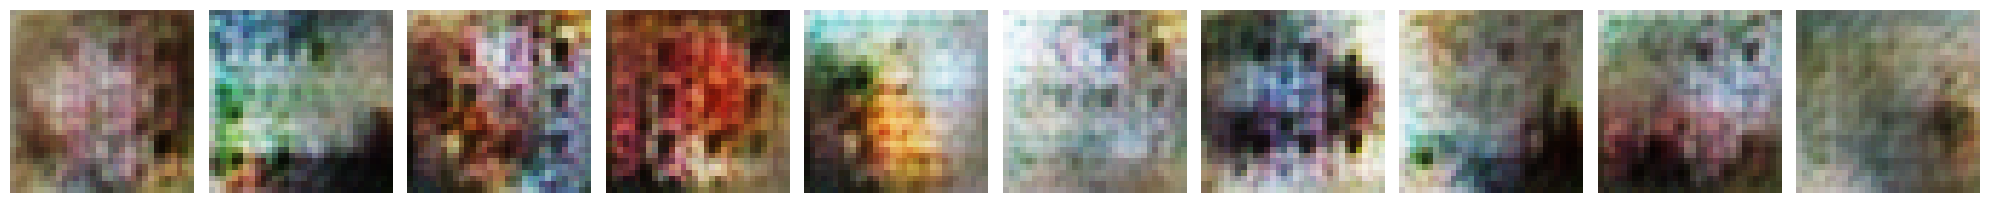

epoch:  15
1/1 [==============================] - 0s 19ms/step


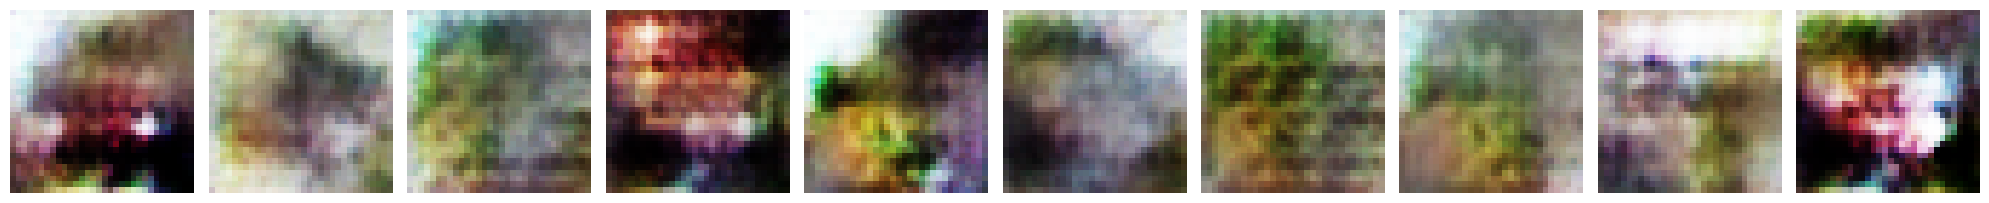

epoch:  16
1/1 [==============================] - 0s 17ms/step


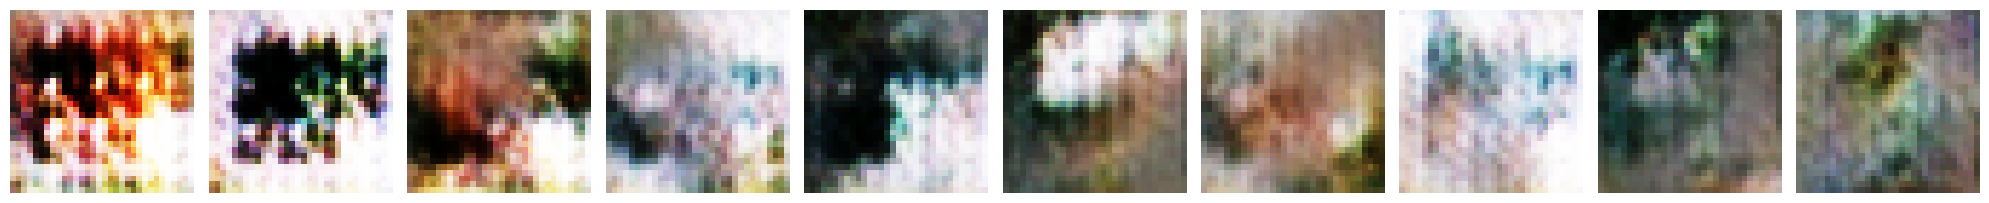

epoch:  17
1/1 [==============================] - 0s 17ms/step


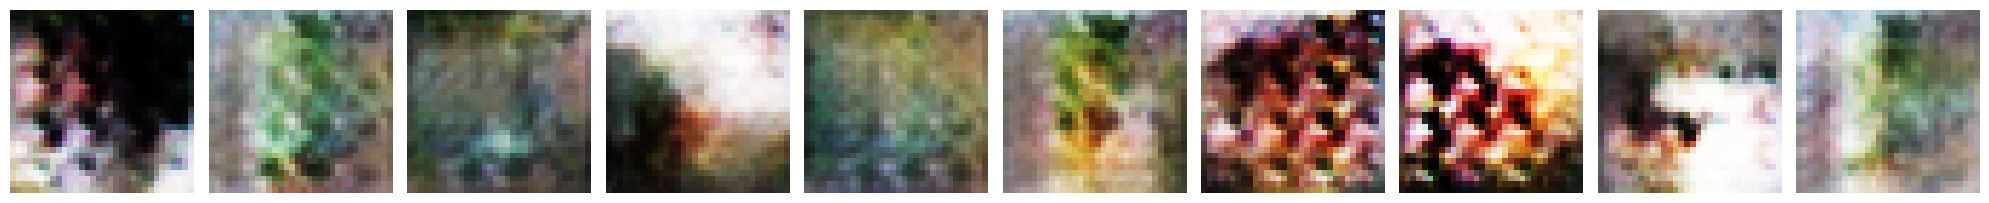

epoch:  18
1/1 [==============================] - 0s 17ms/step


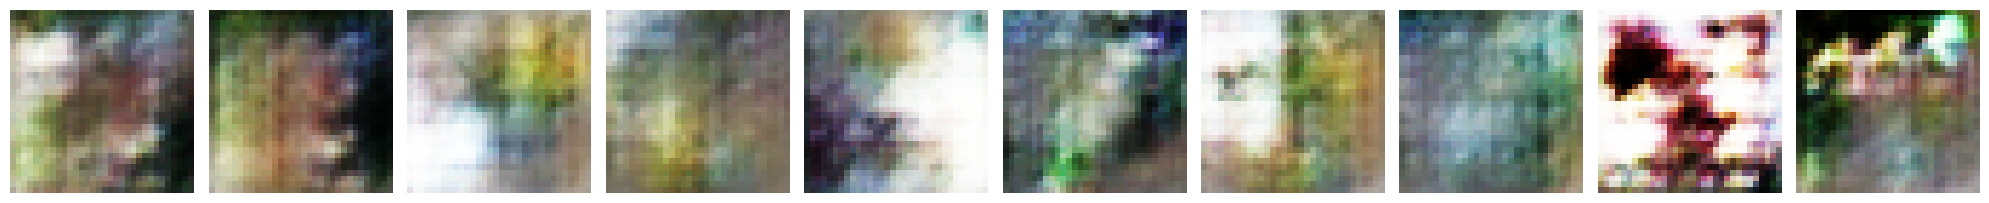

epoch:  19
1/1 [==============================] - 0s 16ms/step


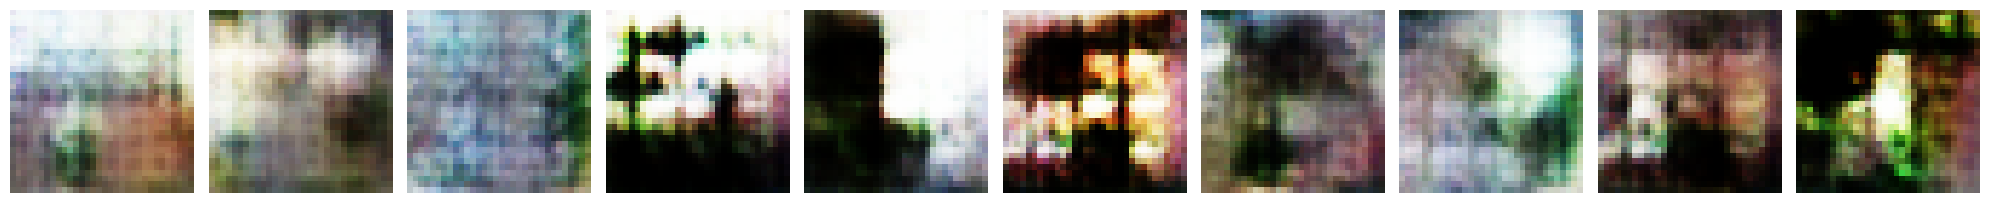

epoch:  20
1/1 [==============================] - 0s 23ms/step


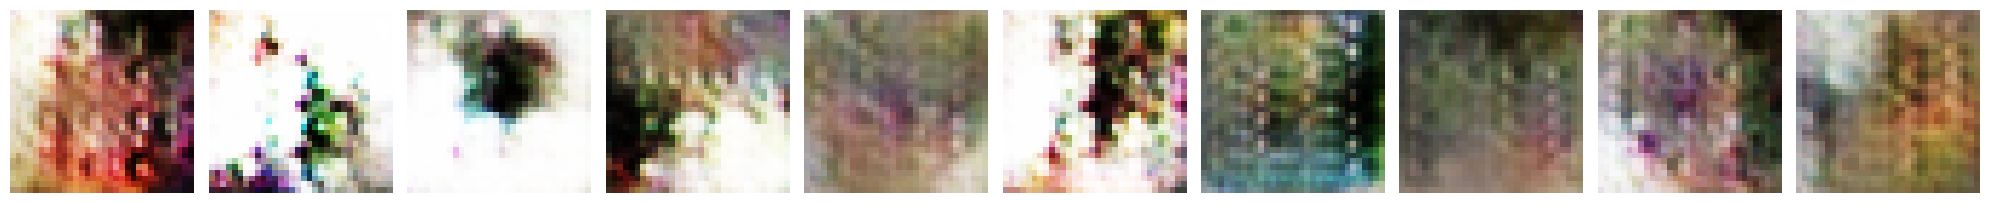

epoch:  21
1/1 [==============================] - 0s 17ms/step


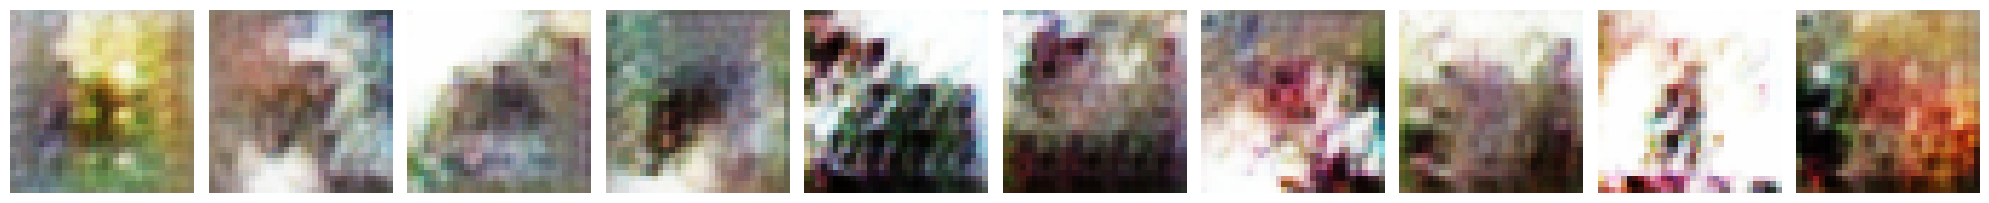

epoch:  22
1/1 [==============================] - 0s 17ms/step


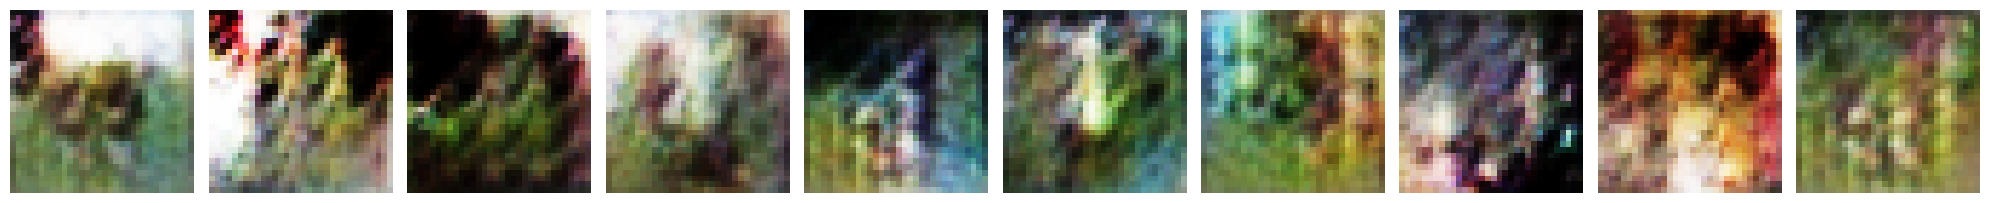

epoch:  23
1/1 [==============================] - 0s 25ms/step


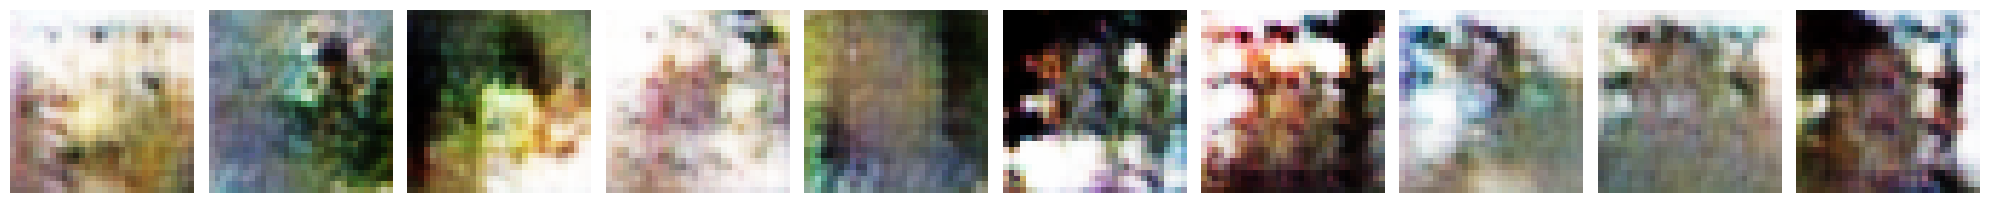

epoch:  24
1/1 [==============================] - 0s 16ms/step


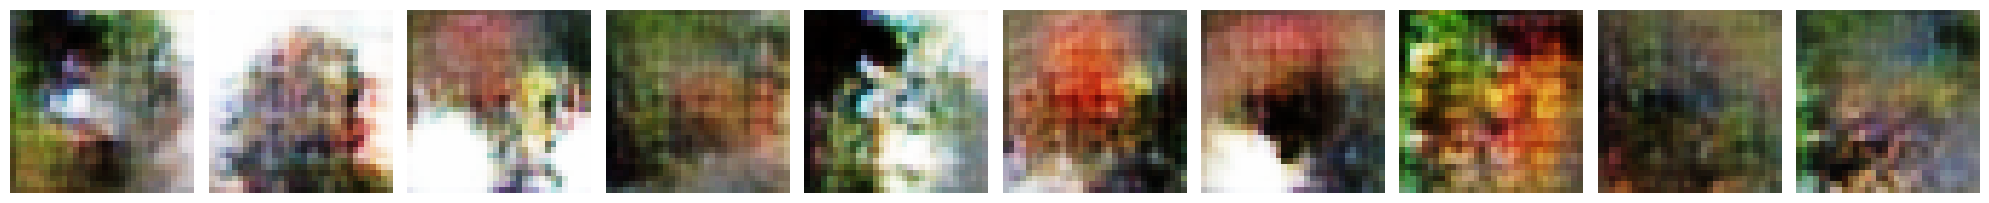

epoch:  25
1/1 [==============================] - 0s 18ms/step


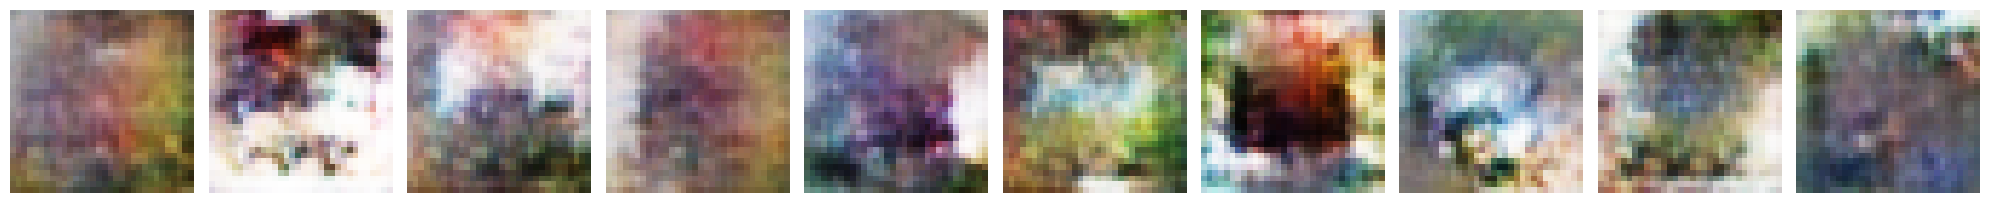

epoch:  26
1/1 [==============================] - 0s 17ms/step


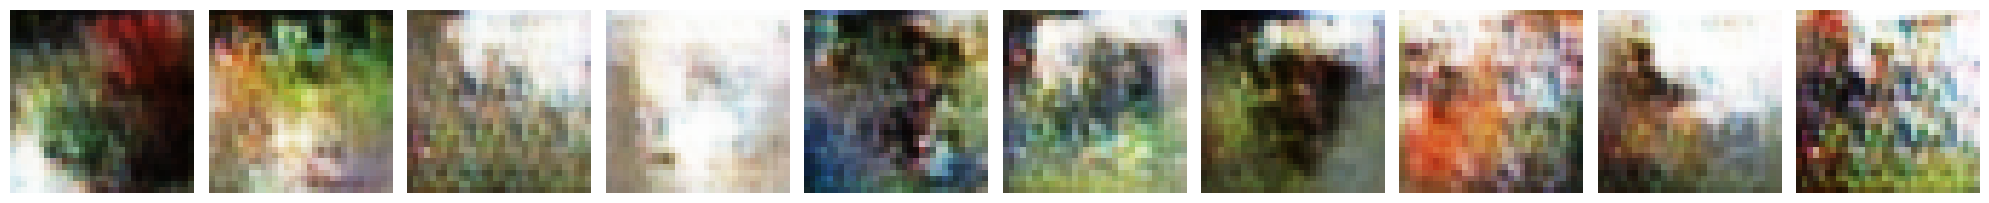

epoch:  27
1/1 [==============================] - 0s 27ms/step


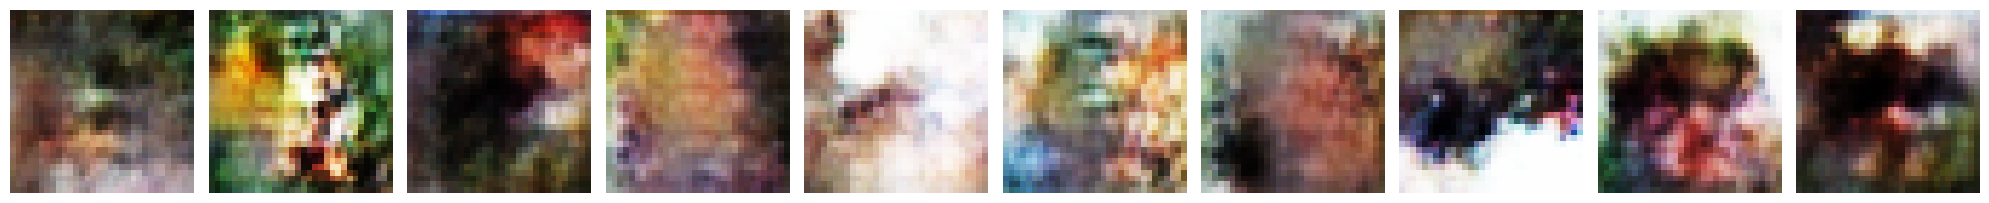

epoch:  28
1/1 [==============================] - 0s 19ms/step


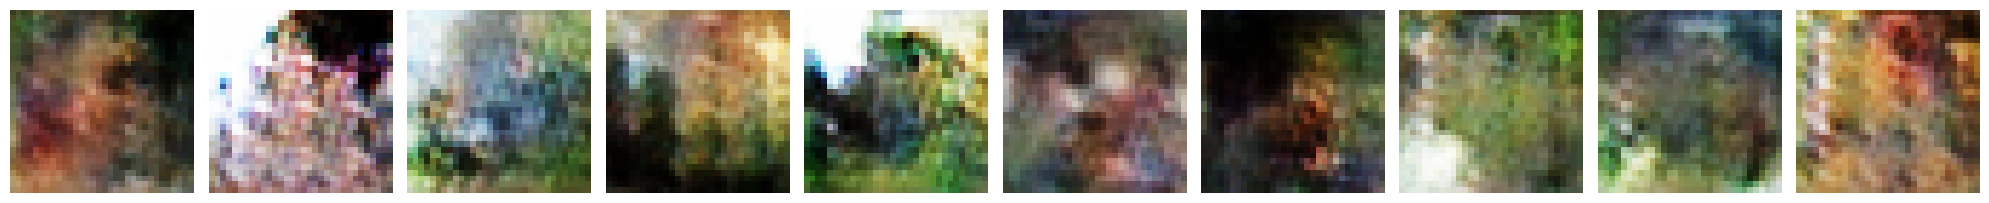

epoch:  29
1/1 [==============================] - 0s 16ms/step


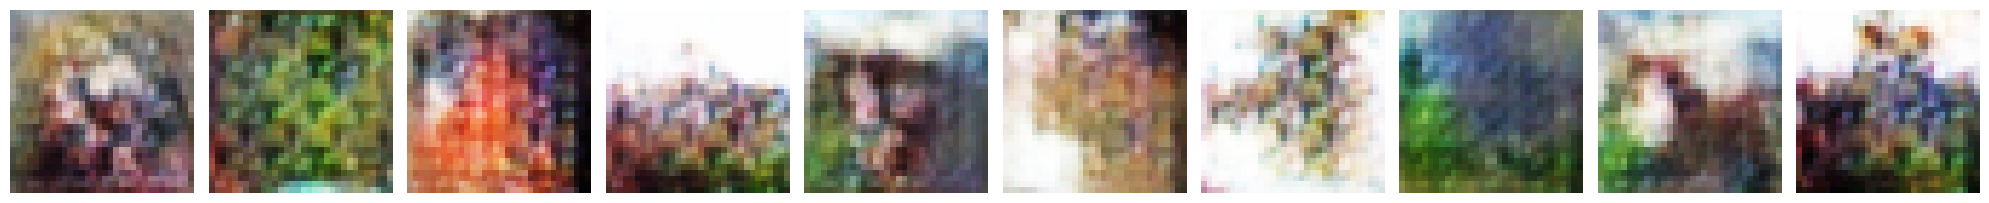

epoch:  30
1/1 [==============================] - 0s 33ms/step


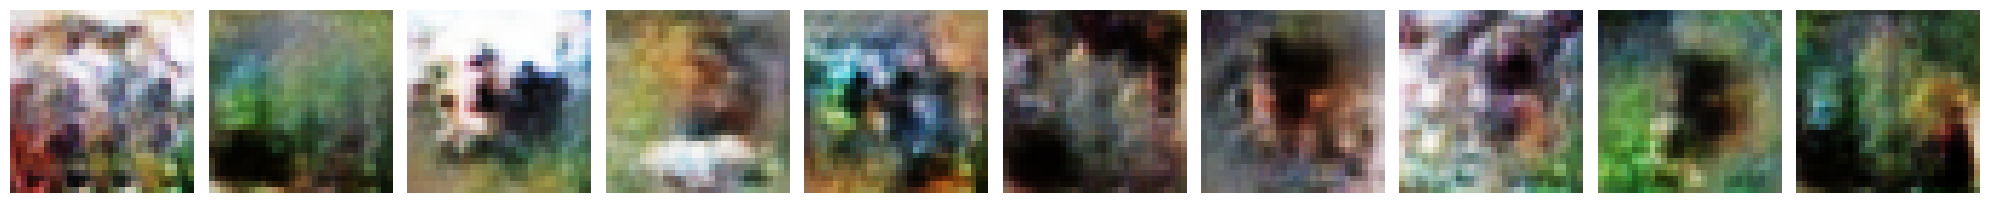

epoch:  31
1/1 [==============================] - 0s 16ms/step


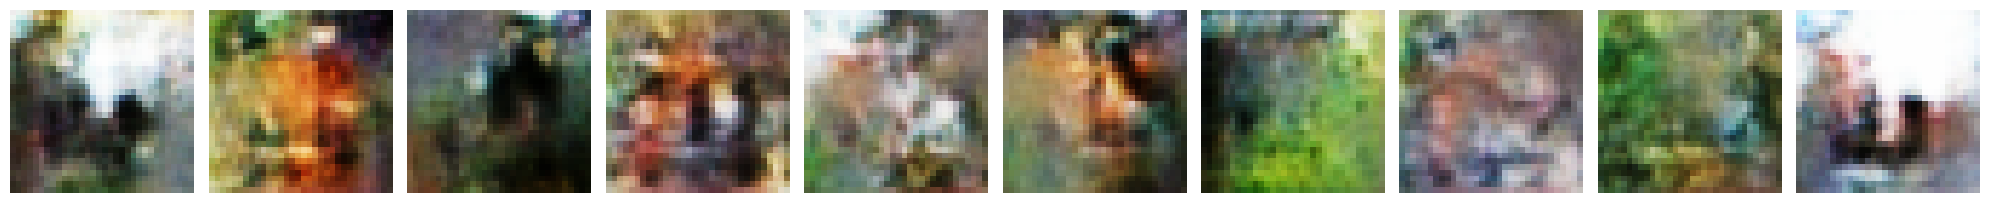

epoch:  32
1/1 [==============================] - 0s 16ms/step


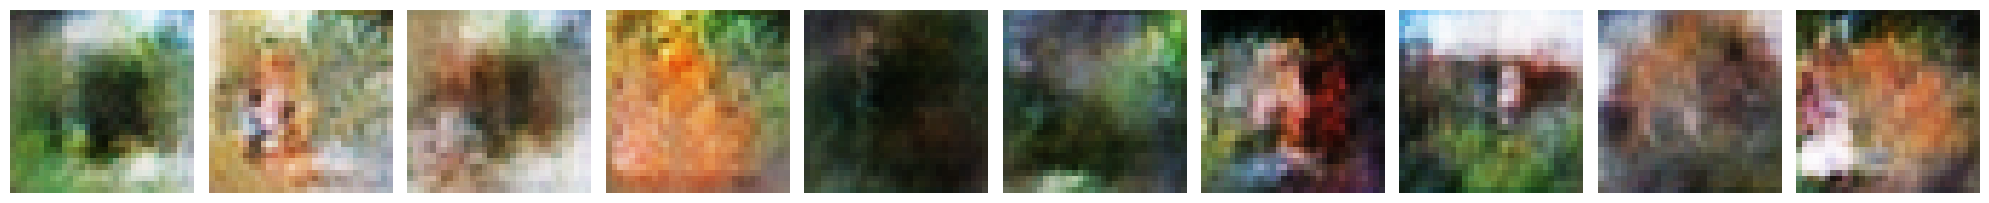

epoch:  33
1/1 [==============================] - 0s 18ms/step


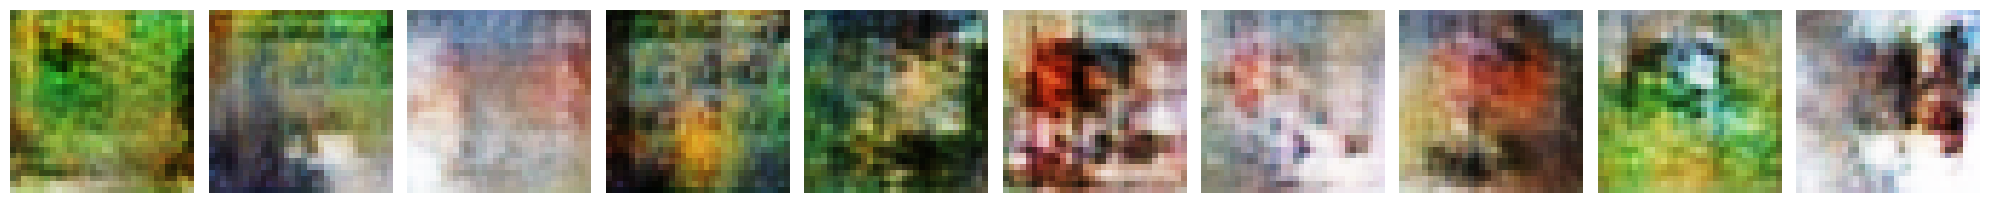

epoch:  34
1/1 [==============================] - 0s 17ms/step


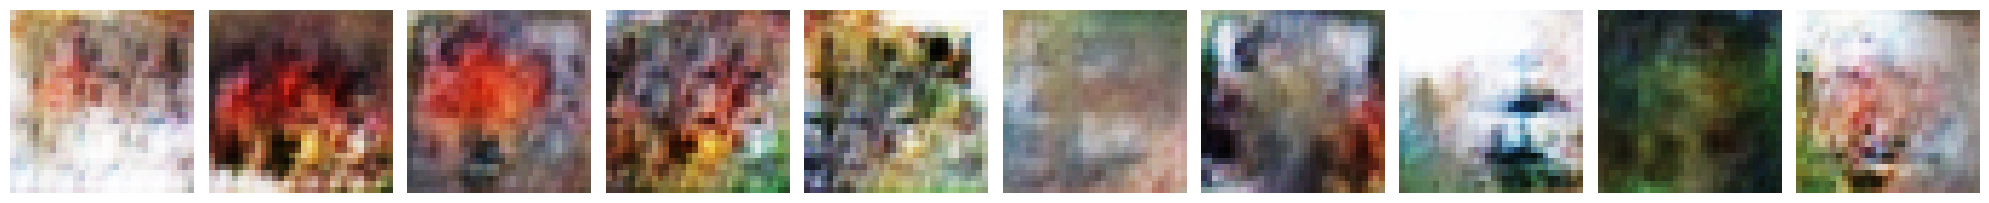

epoch:  35
1/1 [==============================] - 0s 17ms/step


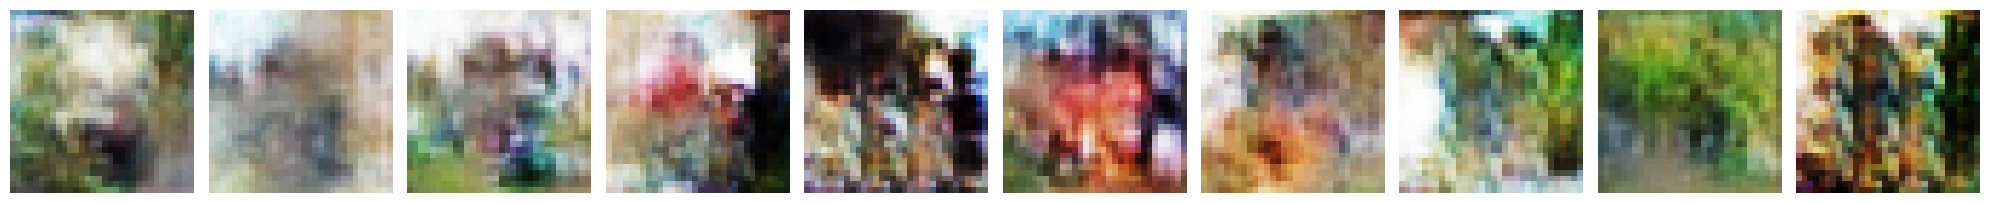

epoch:  36
1/1 [==============================] - 0s 29ms/step


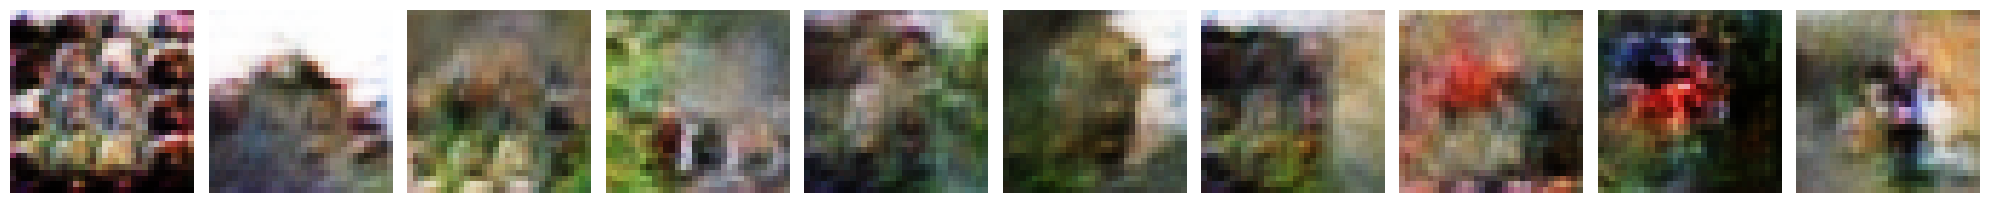

epoch:  37
1/1 [==============================] - 0s 19ms/step


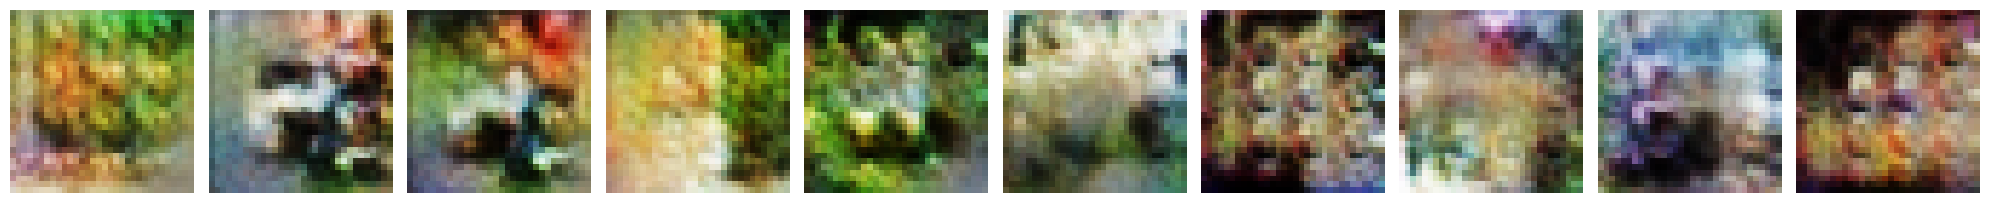

epoch:  38
1/1 [==============================] - 0s 16ms/step


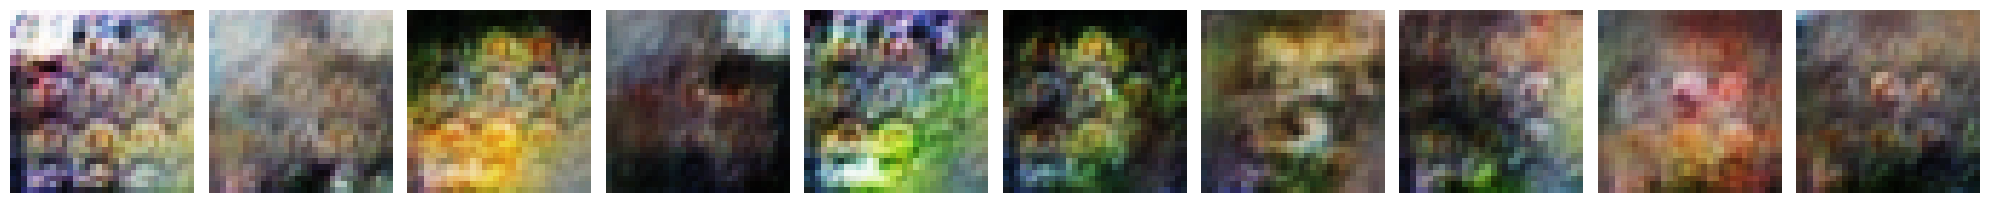

epoch:  39
1/1 [==============================] - 0s 16ms/step


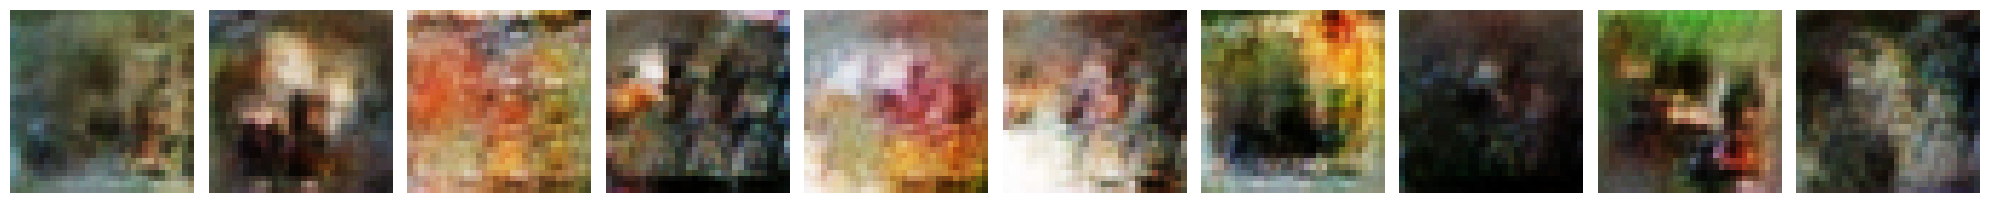

epoch:  40
1/1 [==============================] - 0s 24ms/step


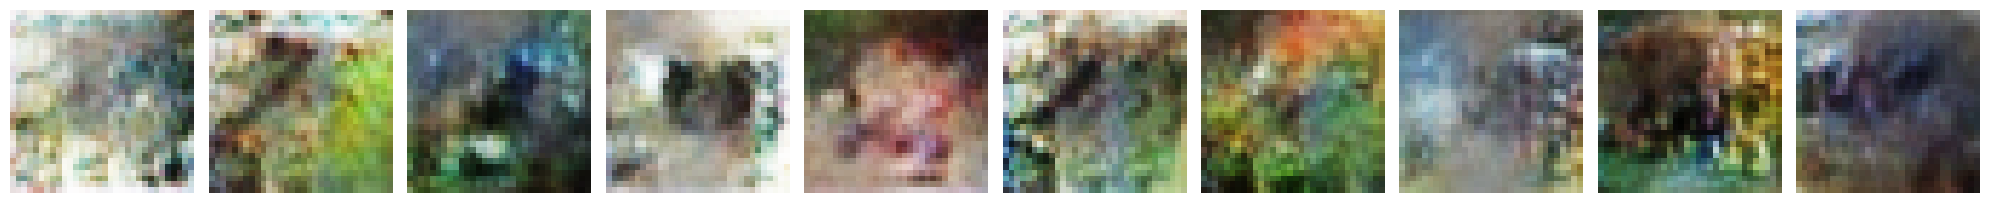

epoch:  41
1/1 [==============================] - 0s 23ms/step


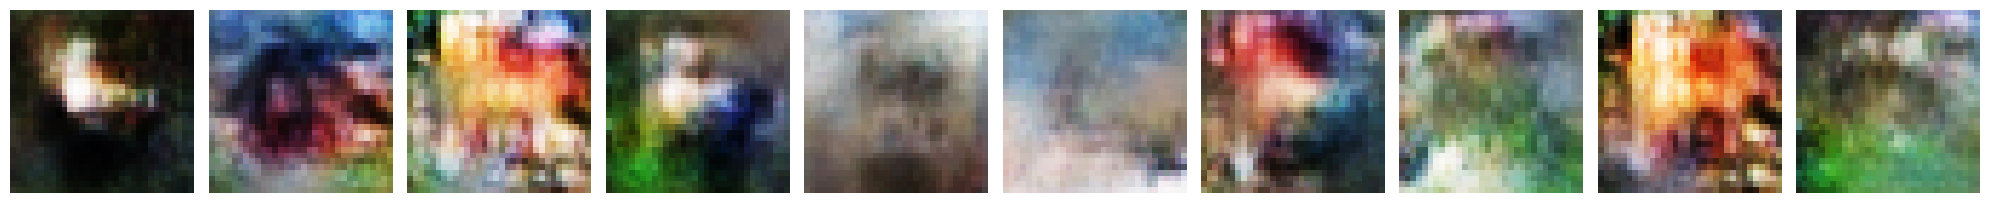

epoch:  42
1/1 [==============================] - 0s 16ms/step


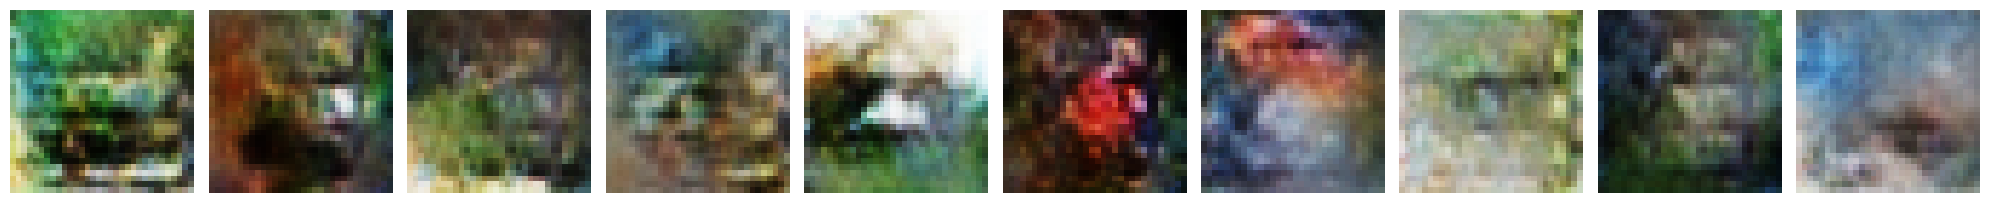

epoch:  43
1/1 [==============================] - 0s 17ms/step


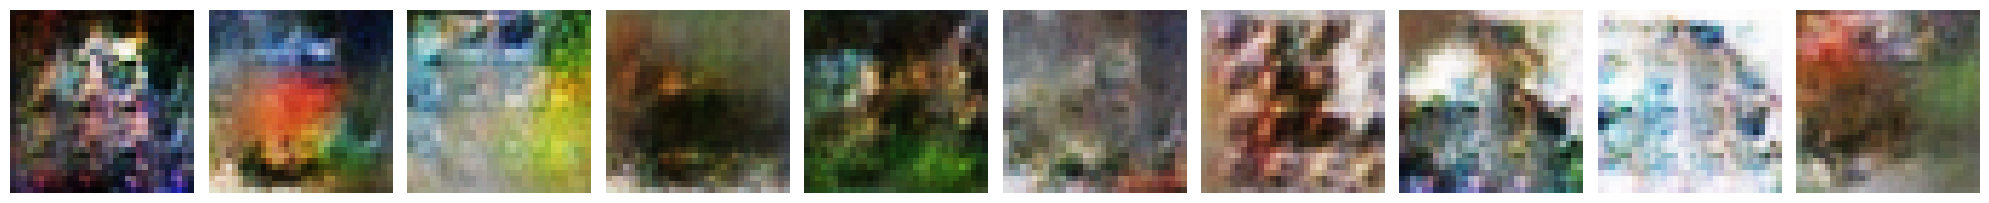

epoch:  44
1/1 [==============================] - 0s 16ms/step


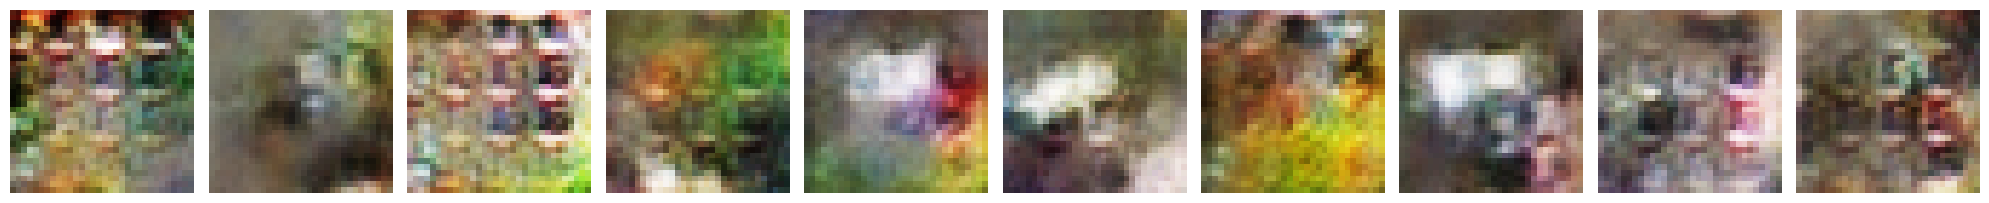

epoch:  45
1/1 [==============================] - 0s 17ms/step


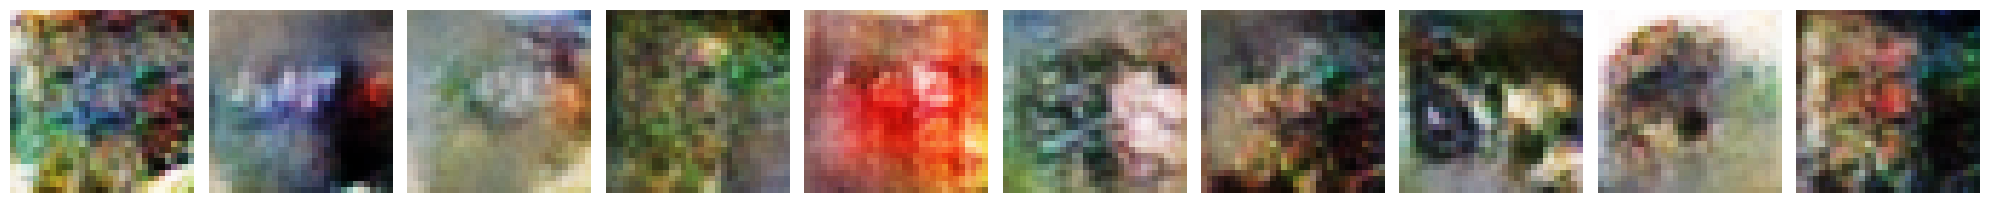

epoch:  46
1/1 [==============================] - 0s 17ms/step


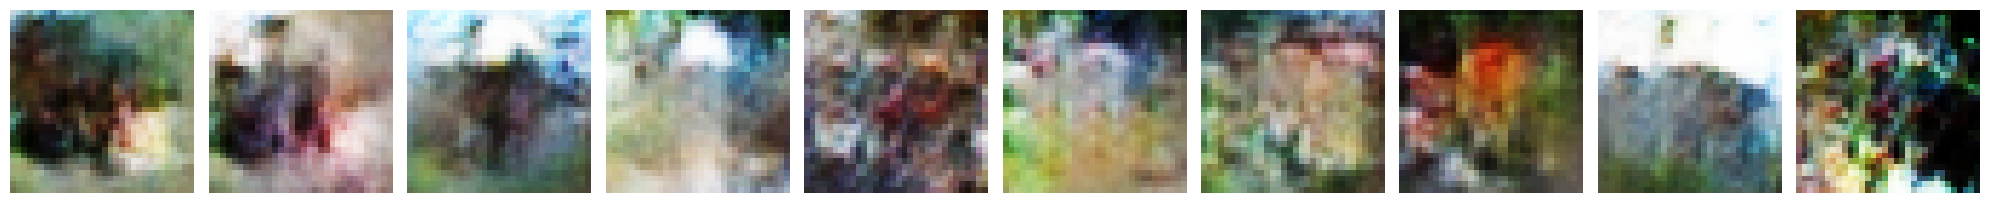

epoch:  47
1/1 [==============================] - 0s 16ms/step


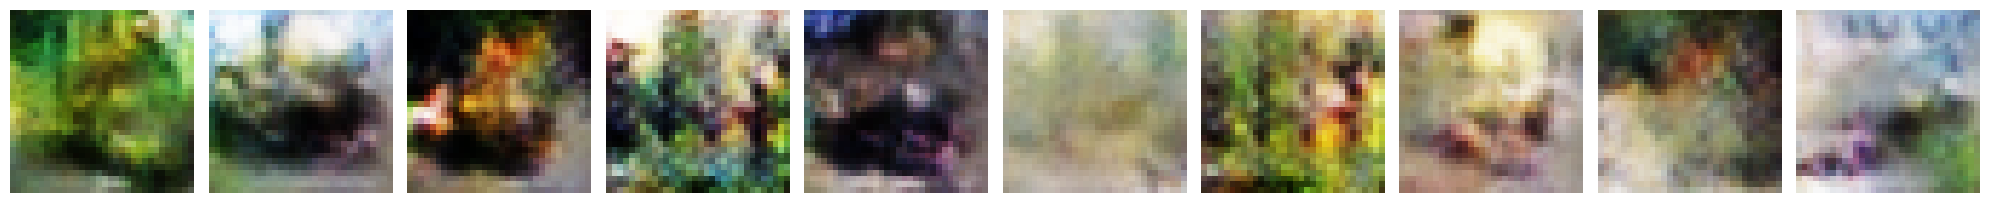

epoch:  48
1/1 [==============================] - 0s 18ms/step


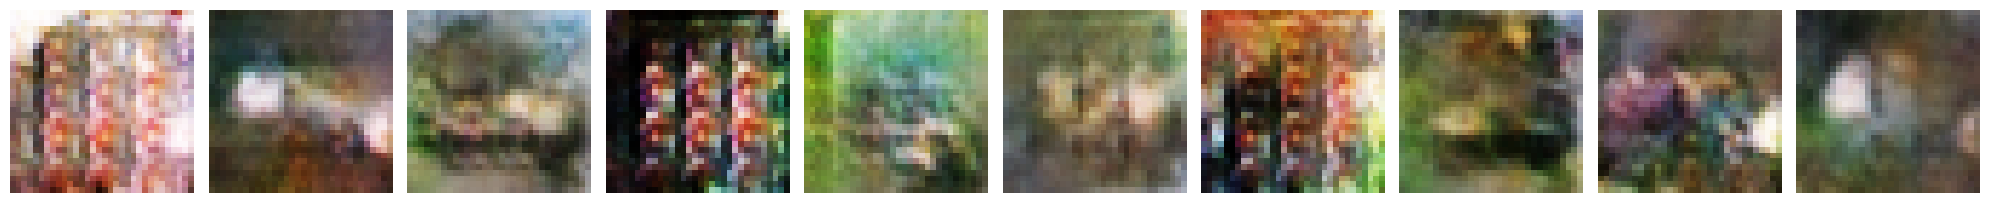

epoch:  49
1/1 [==============================] - 0s 18ms/step


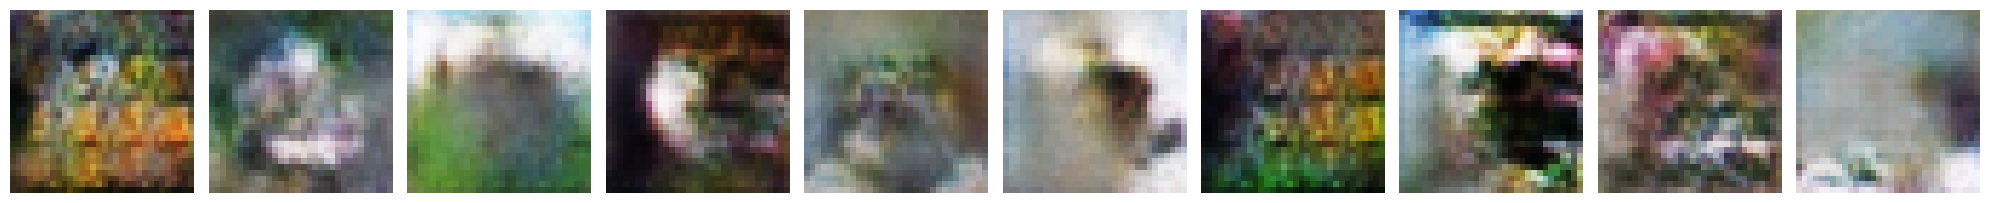

epoch:  50
1/1 [==============================] - 0s 16ms/step


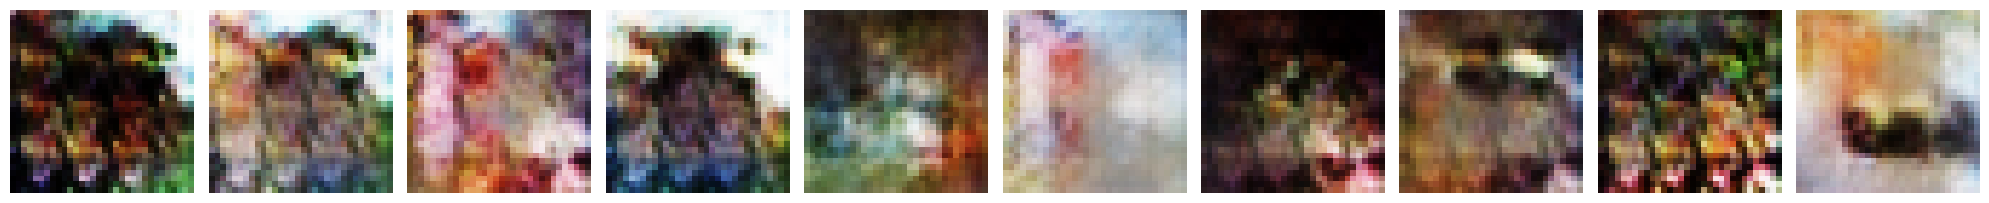

In [22]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)

epochs = 50 # to get good quality images, you should train the model for more than 100 epochs
batch_size = 1024
train_model(epochs, batch_size)

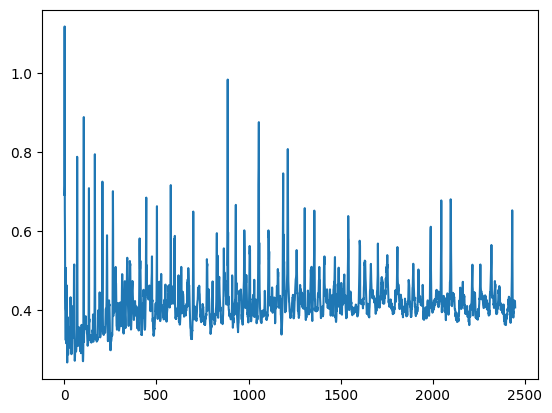

In [23]:
plt.plot(discrim_losses)